## testing for pyarmfinder

In [1]:
import sys,os,subprocess,glob
import pandas as pd
pd.set_option('display.max_columns', 14)
pd.set_option('display.width', 200)
import numpy as np
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import urllib.request
sys.path.append('../')
from pyamrfinder import tools, app
datadir = '../pyamrfinder/data/'
dbdir = app.dbdir

In [2]:
def fetch_sequence_db(name='card'):
    """get sequences"""
    
    path = dbdir
    if not os.path.exists(path):
        os.makedirs(path)
    links = {'card':'https://github.com/tseemann/abricate/raw/master/db/card/sequences',
            'resfinder':'https://raw.githubusercontent.com/tseemann/abricate/master/db/resfinder/sequences',
            'vfdb':'https://raw.githubusercontent.com/tseemann/abricate/master/db/vfdb/sequences'
            }
    if name in links:
        url = links[name]
    else:
        print('no such name')
        return
        
    filename = os.path.join(path,"%s.fa" %name)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return

fetch_sequence_db('resfinder')

In [ ]:
fname='/local/abricate/db/card/sequences'
f=open(fname,'r')
for i in f.readlines():

sp=SeqIO.parse(handle=f,format='fasta')
seqs=[]
print (seqs)

In [76]:
def make_blast_database(filenames):
    """Make blast dbs of multiple input files"""

    rec=[]
    for n in filenames:
        seqs = list(SeqIO.parse(n,'fasta'))
        for s in seqs:
            s.id = n + '~' + s.id
        rec.extend(seqs)
    #ref = list(SeqIO.parse('genomes/ecoli_k12.fa','fasta'))
    #ref[0].id = 'ecoli_k12~1'
    #rec.extend(ref)
    SeqIO.write(rec, 'targets.fasta', 'fasta')
    cmd = 'makeblastdb -dbtype nucl -in targets.fasta'
    subprocess.check_output(cmd, shell=True)
    return

make_blast_database(['../test_files/RF15B.fa','../test_files/RF15A.fa'])

In [103]:
def find_genes(target, ref='card', ident=90, coverage=75, duplicates=False):
    """Find ref genes by blasting the target sequences"""

    path = os.path.join(dbdir,'%s.fa' %ref)
    dbseqs = list(SeqIO.parse(path,'fasta'))
    print ('blasting %s sequences' %len(dbseqs))
    bl = tools.blast_sequences(target, dbseqs, maxseqs=100, evalue=.1,
                               cmd='blastn', show_cmd=True)
    
    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    
    #remove exact and close duplicates
    bl = bl.sort_values(['coverage','pident'], ascending=False).drop_duplicates(['contig','sstart','send'])
    if duplicates == False:
        dist = 20
        bl=bl.sort_values(by=["contig","sstart"])   
        unique = bl.sstart.diff().fillna(dist)
        bl = bl[unique>=dist]
    cols = ['gene','id','qseqid','pident','coverage','sstart','send','contig','filename']
    bl = bl[cols]
    return bl

bl = find_genes('targets.fasta', 'resfinder')

blasting 3077 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


In [ ]:

dist = 20
bl=bl.sort_values(by=["contig","sstart"])
print (bl[:15][bl.columns[:8]])
unique = bl.sstart.diff().fillna(dist)
bl[unique>=dist]


In [97]:
def get_gene_hits(res, gene, filename, db='card'):
    """Get blast hit results"""

    path = os.path.join(dbdir,'%s.fa' %db)
    #dbseqs = SeqIO.to_dict(SeqIO.parse(path,'fasta'))
    dbseqs = tools.fasta_to_dataframe(path)
    dbseqs['gene'] = dbseqs.description.apply(lambda x: x.split('~~~')[1],1)
    #print (dbseqs)
    x = res[res.gene==gene]
   
    found=[]
    contigs = []
    for i,r in x.iterrows():
        name = r.id
        print (name)
        #if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse(r.filename,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print (name, r.gene, r['coverage'], r['pident'], len(s), node)
        #add card seq
        contigs.append(seqs[node])

    row = dbseqs[dbseqs.gene==gene].iloc[0]
    print (row)
    found.append(SeqRecord(id=row['name'],seq=Seq(row.sequence)))
    seqfile = 'temp.fa'
    SeqIO.write(found, seqfile,'fasta')
    SeqIO.write(contigs,'contigs.fa','fasta')
    #maaft_alignment(seqfile)
    aln = tools.clustal_alignment(seqfile)
    tools.show_alignment(aln)
    #print (aln)
    return


In [ ]:
get_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', 'resfinder')

In [99]:
def pivot_blast_results(bl):
    x = bl.drop_duplicates(['sstart'])
    m = pd.pivot_table(x, index='id', columns='gene', values='pident')#, aggfunc=np.size)   
    #m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
    #m = m.drop('ecoli_k12')
    return m

m = pivot_blast_results(bl)
m

gene,aadA24_1,aph(3'')-Ib_2,aph(4)-Ia_1,aph(6)-Id_4,dfrA1_17
id,,,,,
RF15B.fa,98.187,100.0,100.0,99.88,99.577


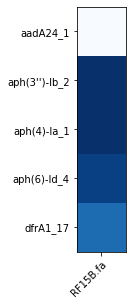

In [100]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

def plot_heatmap(m, fig=None, title=''):

    from matplotlib.gridspec import GridSpec
    l=l=1+int(len(m)/30)
    if fig == None:
        fig = plt.figure()
    gs = fig.add_gridspec(1, l)
    chunks = np.array_split(m,l)
    i=0
    for df in chunks:
        ax = fig.add_subplot(gs[0,i])
        im = ax.imshow(df, cmap='Blues')
        ax.set_xticks(np.arange(len(df.T)))
        ax.set_yticks(np.arange(len(df)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        i+=1
    fig.suptitle(title)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=1.2, bottom=.2)
    return

fig = plt.figure(figsize=(10,5))
plot_heatmap(m.T, fig=fig)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


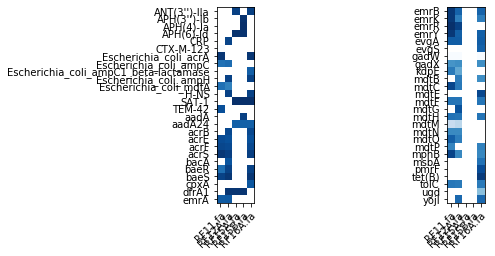

In [102]:
# run in sequence

def run(filenames, db='card'):
    """Run pipeline"""
    
    fetch_sequence_db(db)
    make_blast_database(filenames)
    bl = find_genes('targets.fasta', db)
    #find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', db)
    bl.to_csv('%s_results.csv' %db)
    m = pivot_blast_results(bl)
    #print (m)
    plot_heatmap(m.T)
    m.to_csv('%s_matrix.csv' %db)
    return

inpath = '../test_files/'
filenames = glob.glob(os.path.join(inpath,'*.fa*'))
#run(filenames, db='resfinder')
run(filenames, db='card')

In [93]:
def abricate(filename, db='card',id=None):
    
    cmd = '/local/abricate/bin/abricate %s -db %s --mincov 50 --minid 90 > temp.tab' %(filename,db)
    print (cmd)
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab',sep='\t')
    id = os.path.basename(filename)
    df['id'] = id
    return df

x = abricate('../test_files/RF15B.fa')

/local/abricate/bin/abricate ../test_files/RF15B.fa -db card --mincov 50 --minid 90 > temp.tab


In [94]:
make_blast_database(['../test_files/RF15B.fa'])
y = find_genes('targets.fasta', 'card', coverage=50, ident=90)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


In [95]:
print (x.GENE)
print (y.gene)

0      CTX-M-144
1           aadA
2          SAT-1
3      APH(6)-Id
4    APH(3'')-Ib
5      AAC(3)-IV
6      APH(4)-Ia
Name: GENE, dtype: object
12      CTX-M-107
85         aadA24
76           aadA
73          SAT-1
92          dfrA1
7       APH(6)-Id
3     APH(3'')-Ib
4       APH(4)-Ia
Name: gene, dtype: object
